In [57]:
import sys
import os

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [58]:
# retrive data 
df = pd.read_csv("./core_exchange.csv", 
                #  index_col=0, 
                 parse_dates=True)

df.head()

,id,currency_name,bank_name,buy_rate,sell_rate,increment_amount,created_at,updated_at
0,1300,USD,Hibret Bank,105.1586,118.8292,NaN,2024-08-25 09:05:28.687571+00,2024-08-25 09:05:28.687592+00
1,2,USD,Bank of Abyssinia,104.6247,117.1797,NaN,2024-08-23 03:05:19.612498+00,2024-08-23 03:05:19.612571+00
2,3,GBP,Bank of Abyssinia,130.4970,146.1566,NaN,2024-08-23 03:05:19.618773+00,2024-08-23 03:05:19.618785+00
3,4,EUR,Bank of Abyssinia,116.6042,130.5967,NaN,2024-08-23 03:05:19.619882+00,2024-08-23 03:05:19.619893+00
4,5,AED,Bank of Abyssinia,28.4879,31.9064,NaN,2024-08-23 03:05:19.620869+00,2024-08-23 03:05:19.620877+00


In [59]:
print("Sum of total rows in the DataFrame:")
print(len(df))
print("Missing values in each column:")
print(df.isnull().sum())

print("\nData types of each column:")
print(df.dtypes)

print("\nSummary statistics of the DataFrame:")
print(df.describe())

Sum of total rows in the DataFrame:
134801
Missing values in each column:
id                       0
currency_name            0
bank_name                0
buy_rate                 0
sell_rate                0
increment_amount    134801
created_at               0
updated_at               0
dtype: int64

Data types of each column:
id                    int64
currency_name        object
bank_name            object
buy_rate            float64
sell_rate           float64
increment_amount    float64
created_at           object
updated_at           object
dtype: object

Summary statistics of the DataFrame:
                  id       buy_rate      sell_rate  increment_amount
count  134801.000000  134801.000000  134801.000000               0.0
mean    71237.264048      90.706025     179.986443               NaN
std     39233.725897      63.469969    7270.592196               NaN
min         2.000000      -1.000000      -1.000000               NaN
25%     37704.000000      32.236600      33.3877

In [60]:
# drop the increment_amount -> all are NaN
df.drop(columns=["increment_amount"], inplace=True)

In [61]:
# convert the date columns to datetime (auto-infer format, handle mixed formats)
df['created_at'] = pd.to_datetime(df['created_at'], format='mixed', dayfirst=True)
df['updated_at'] = pd.to_datetime(df['updated_at'], format='mixed', dayfirst=True)

In [62]:
df.head()

,id,currency_name,bank_name,buy_rate,sell_rate,created_at,updated_at
0,1300,USD,Hibret Bank,105.1586,118.8292,2024-08-25 09:05:28.687571+00:00,2024-08-25 09:05:28.687592+00:00
1,2,USD,Bank of Abyssinia,104.6247,117.1797,2024-08-23 03:05:19.612498+00:00,2024-08-23 03:05:19.612571+00:00
2,3,GBP,Bank of Abyssinia,130.4970,146.1566,2024-08-23 03:05:19.618773+00:00,2024-08-23 03:05:19.618785+00:00
3,4,EUR,Bank of Abyssinia,116.6042,130.5967,2024-08-23 03:05:19.619882+00:00,2024-08-23 03:05:19.619893+00:00
4,5,AED,Bank of Abyssinia,28.4879,31.9064,2024-08-23 03:05:19.620869+00:00,2024-08-23 03:05:19.620877+00:00


In [ ]:
# out lier detection - using rolling window 

# Set datetime index
df = df.set_index('created_at').sort_index()

# Sort values for groupby rolling
df = df.sort_values(['currency_name', 'created_at'])

def rolling_outlier_detection(group, window=7, k=1.5):
    # Calculate rolling median and IQR for buy_rate
    buy_median = group['buy_rate'].rolling(window=window, center=True).median()
    buy_q1 = group['buy_rate'].rolling(window=window, center=True).quantile(0.25)
    buy_q3 = group['buy_rate'].rolling(window=window, center=True).quantile(0.75)
    buy_iqr = buy_q3 - buy_q1
    
    buy_lower = buy_median - k * buy_iqr
    buy_upper = buy_median + k * buy_iqr
    buy_outliers = (group['buy_rate'] < buy_lower) | (group['buy_rate'] > buy_upper)
    
    # Calculate rolling median and IQR for sell_rate
    sell_median = group['sell_rate'].rolling(window=window, center=True).median()
    sell_q1 = group['sell_rate'].rolling(window=window, center=True).quantile(0.25)
    sell_q3 = group['sell_rate'].rolling(window=window, center=True).quantile(0.75)
    sell_iqr = sell_q3 - sell_q1
    
    sell_lower = sell_median - k * sell_iqr
    sell_upper = sell_median + k * sell_iqr
    sell_outliers = (group['sell_rate'] < sell_lower) | (group['sell_rate'] > sell_upper)
    
    return pd.DataFrame({
        'buy_rate': group['buy_rate'],
        'buy_rolling_median': buy_median,
        'buy_lower_bound': buy_lower,
        'buy_upper_bound': buy_upper,
        'buy_is_outlier': buy_outliers,
        
        'sell_rate': group['sell_rate'],
        'sell_rolling_median': sell_median,
        'sell_lower_bound': sell_lower,
        'sell_upper_bound': sell_upper,
        'sell_is_outlier': sell_outliers,
    }, index=group.index)

# Apply per currency_name
result = df.groupby('currency_name').apply(rolling_outlier_detection).reset_index(level=0)

# Inspect flagged outliers
print(result[result['buy_is_outlier'] | result['sell_is_outlier']].head())

# Save or merge back as needed
    



Rolling states for buy_rate:
  currency_name  level_1  buy_rate  rolling_median  lower_bound  upper_bound  \
0           AED        0   14.1591             NaN          NaN          NaN   
1           AED        1   14.1591             NaN          NaN          NaN   
2           AED        2   14.1604             NaN          NaN          NaN   
3           AED        3   14.1604             NaN          NaN          NaN   
4           AED        4   14.1632             NaN          NaN          NaN   

   outliers  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  


/tmp/ipykernel_386851/1514196935.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby('currency_name').apply(rolling_states).reset_index()



Frequency of each currency:
currency_name
EUR                20024
GBP                20005
USD                19976
AED                17520
SAR                14164
CAD                11832
CHF                 9055
CNY                 4963
SEK                 3622
NOK                 2627
JPY                 2017
DKK                 1503
AUD                 1343
ZAR                 1289
KWD                 1198
INR                 1193
KES                 1192
DJF                 1190
SDR                   67
XAF                    9
Canadian Dollar        8
GBE                    4
Name: count, dtype: int64

Frequency of each bank_name:
bank_name
Commercial Bank of Ethiopia     20482
Bank of Abyssinia               11660
Global Bank                      8331
Tsehay Bank                      7518
Amhara Bank                      7485
Ahadu Bank                       7470
Siinqee Bank                     7437
Enat Bank                        7054
Awash Bank                       6726

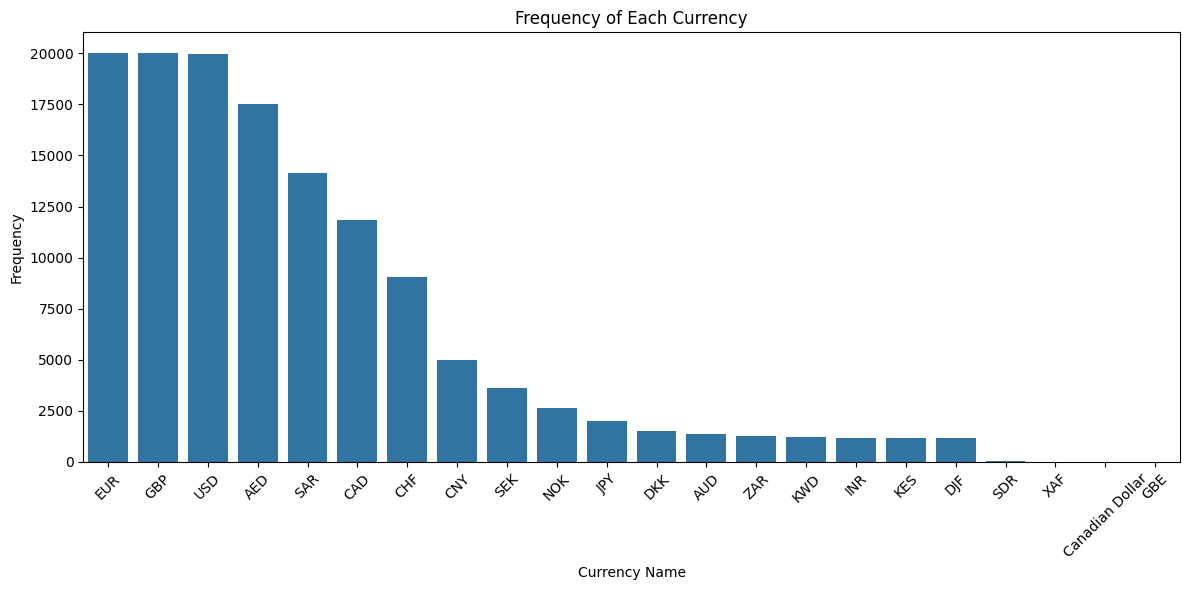

In [ ]:
# descriptive analysis - 

# frequency of currency_name

print("\nFrequency of each currency:")
print(df['currency_name'].value_counts())

print("\nFrequency of each bank_name:")
print(df['bank_name'].value_counts())

# plot the frequency of currency_name
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='currency_name', order=df['currency_name'].value_counts
().index)
plt.title('Frequency of Each Currency')
plt.xticks(rotation=45)
plt.xlabel('Currency Name')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [ ]:
# mean, median, and std for buy_rate and sell_rate 

print("\nMean, Median, and Standard Deviation for buy_rate:")
print("Mean:", df['buy_rate'].mean())
print("Median:", df['buy_rate'].median())
print("Standard Deviation:", df['buy_rate'].std())

print("\nMean, Median, and Standard Deviation for sell_rate:")
print("Mean:", df['sell_rate'].mean())
print("Median:", df['sell_rate'].median())
print("Standard Deviation:", df['sell_rate'].std())


Mean, Median, and Standard Deviation for buy_rate:
Mean: 90.70602469343699
Median: 108.551
Standard Deviation: 63.46996884129087

Mean, Median, and Standard Deviation for sell_rate:
Mean: 179.98644280161125
Median: 118.8292
Standard Deviation: 7270.592196080238


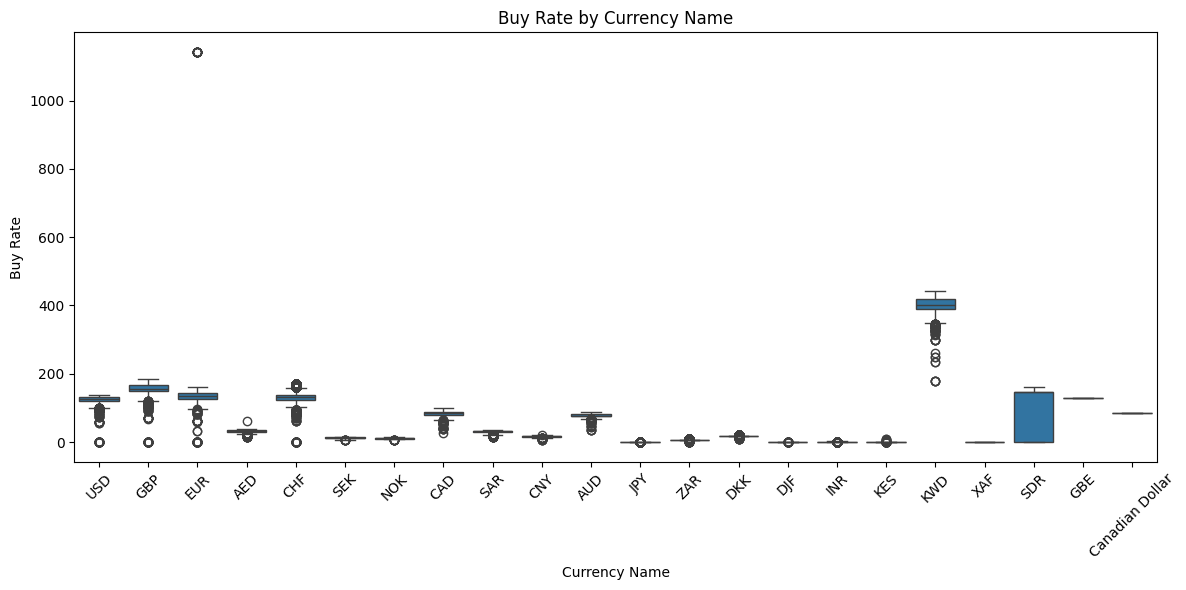

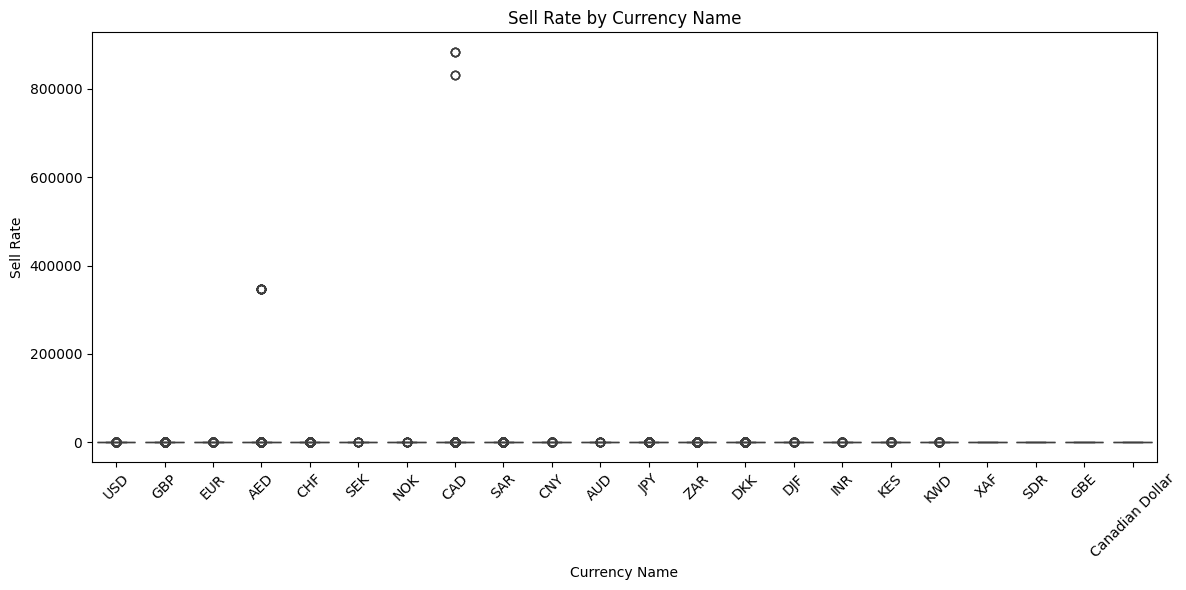

In [ ]:
# Bivariate analysis 

# compare buy_rate for each currency_name
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='currency_name', y='buy_rate')
plt.title('Buy Rate by Currency Name')
plt.xticks(rotation=45)
plt.xlabel('Currency Name')
plt.ylabel('Buy Rate')
plt.tight_layout()
plt.show()

# Compare sell_rate by currency_name
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='currency_name', y='sell_rate')
plt.title('Sell Rate by Currency Name')
plt.xticks(rotation=45)
plt.xlabel('Currency Name')
plt.ylabel('Sell Rate')
plt.tight_layout()
plt.show()

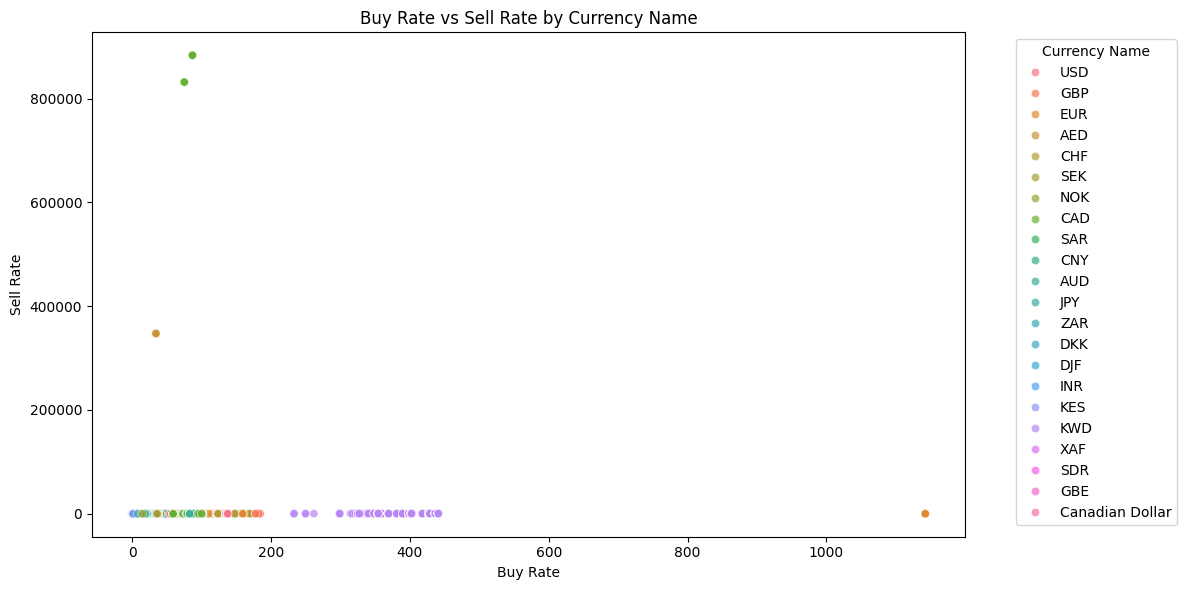


Correlation Matrix:
           buy_rate  sell_rate
buy_rate   1.000000   0.002836
sell_rate  0.002836   1.000000


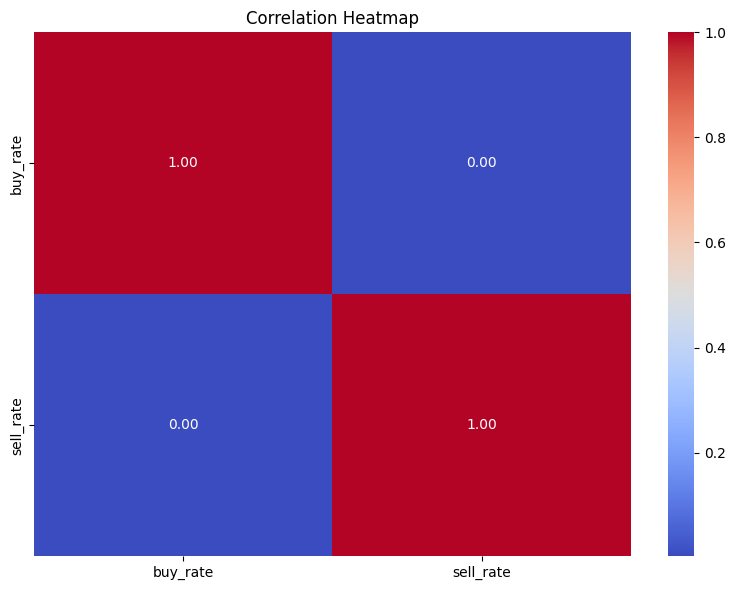

In [ ]:
# Parallel analysis of buy_rate and sell_rate of each currency_name
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='buy_rate', y='sell_rate', hue='currency_name', alpha=0.7)
plt.title('Buy Rate vs Sell Rate by Currency Name')
plt.xlabel('Buy Rate')
plt.ylabel('Sell Rate')
plt.legend(title='Currency Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Correlation analysis
correlation_matrix = df[['buy_rate', 'sell_rate']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()



In [ ]:
# time series analysis 

# time summary 
print("Data Range:", df['created_at'].min(), "to", df['created_at'].max())
print("Counts per day: ", df.set_index('created_at').resample('D').size().head())


Data Range: 2024-07-23 00:00:00+00:00 to 2025-08-11 07:20:43.303962+00:00
Counts per day:  created_at
2024-07-23 00:00:00+00:00    25
2024-07-24 00:00:00+00:00    25
2024-07-25 00:00:00+00:00    25
2024-07-26 00:00:00+00:00    25
2024-07-27 00:00:00+00:00     0
Freq: D, dtype: int64


In [ ]:
# daily average buy_rate and sell_rate
daily_avg = df.resample('D').mean(numeric_only=True)
print("\nDaily Average Buy Rate and Sell Rate:")
print(daily_avg[['buy_rate', 'sell_rate']].head())



Daily Average Buy Rate and Sell Rate:
                            buy_rate  sell_rate
created_at                                     
2024-07-23 00:00:00+00:00  31.064640  31.685928
2024-07-24 00:00:00+00:00  31.017468  31.637816
2024-07-25 00:00:00+00:00  31.016760  31.637096
2024-07-26 00:00:00+00:00  31.010992  31.631216
2024-07-27 00:00:00+00:00        NaN        NaN


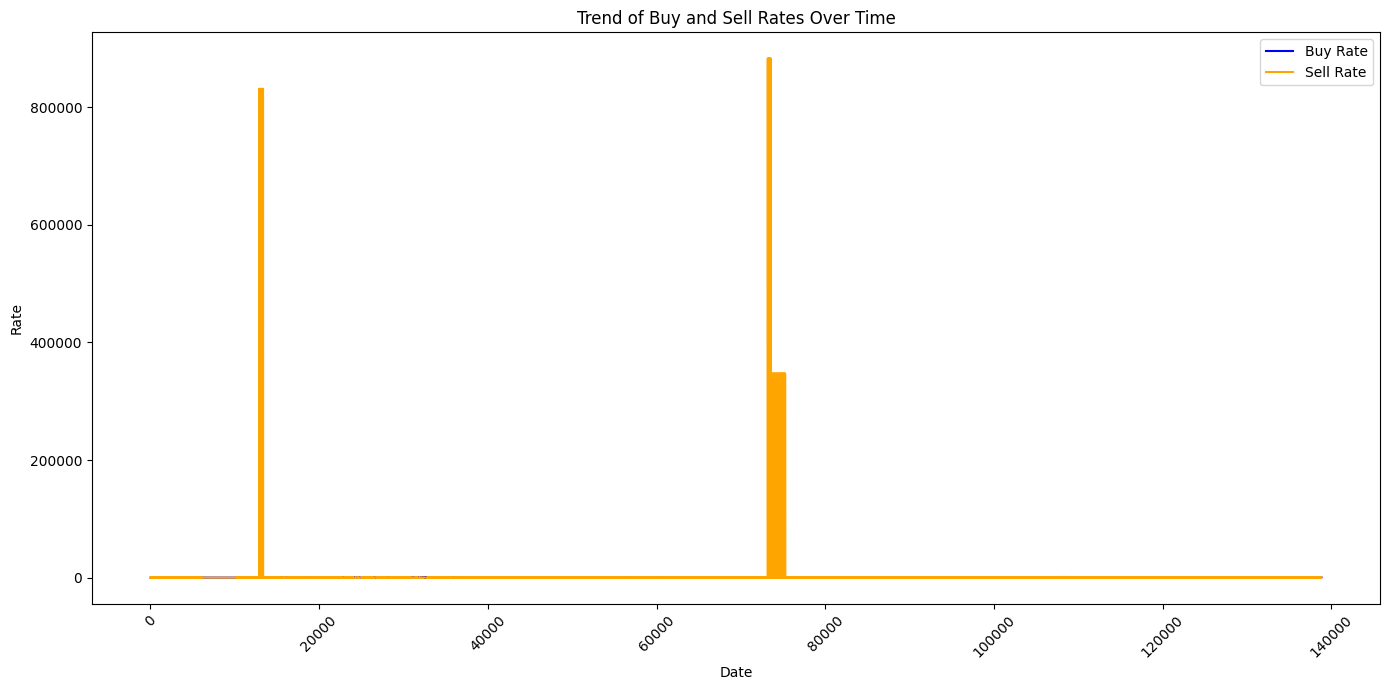

In [ ]:
#  plot the trend of buy_rate and sell_rate over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x=df.index, y='buy_rate', label='Buy Rate', color='blue')
sns.lineplot(data=df, x=df.index, y='sell_rate', label='Sell Rate', color='orange')
plt.title('Trend of Buy and Sell Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()